## Biophysical branching model

Lingchong You

In this notebook, we leverage Jax in order to perform GPU accelerated simulation of branching model by simulating nutrient diffusion and density-dependent diffusion of cell dispersal.


In [109]:
%reset -f
# Import necessary libraries
import jax
import jax.numpy as jnp
from jax import jit, lax
import matplotlib.pyplot as plt
from collections import namedtuple
from jax import random
import os
import numpy as np
import time



### Model description

(This model was partially based on a model formulation initially developed by Nan Luo.)

We have four fields representing nutrient ($N$), producer ($P$), grower ($G$), and surfactant ($S$). The reaction-diffusion equations for each of these fields can be written as follows:

#### 1. **Nutrient ($N$)**

$$
\frac{\partial N}{\partial t} = -b_N f_G (a_P P + a_G G) + D_N \nabla^2 N
$$

where:

$$
f_G = \frac{N}{N + K_N} \left(1 - \frac{C}{C_{\text{max}}}\right), \quad C = P + G
$$

#### 2. **Producer ($P$)**

$$
\frac{\partial P}{\partial t} = a_P f_G P - k_G P + k_P f_T G + \nabla \cdot (D_P \nabla P)
$$

where:

$$
f_T = \frac{K_T^n}{N^n + K_T^n}, \quad D_P = k_D (1 + \text{noise}) S
$$

#### 3. **Grower ($G$)**

$$
\frac{\partial G}{\partial t} = a_G f_G G + k_G P - k_P f_T G + \nabla \cdot (D_G \nabla G)
$$

where:

$$
D_G = k_D (1 + \text{noise}) S
$$

#### 4. **Surfactant ($S$)**

$$
\frac{\partial S}{\partial t} = a_S P f - b_S S + D_S \nabla^2 S
$$

where:

$$
f = f_{QS} f_E f_P, \quad f_{QS} = \frac{C^d}{C^d + K_C^d}, \quad f_E = \frac{K_E^a}{N^a + K_E^a}, \quad f_P = \frac{N^b}{N^b + K_P^b}
$$

### Summary of Dynamics

- **Nutrient ($N$)**: Decreases due to consumption by both producers and growers.
- **Producer ($P$)**: Growth depends on available nutrients, and producers can also decay or get converted into growers.
- **Grower ($G$)**: Grows using nutrients and can be produced from producers.
- **Surfactant ($S$)**: Produced by the producer and decays naturally. The surfactant affects the diffusivity of both the producer and grower fields.

These equations describe a reaction-diffusion system that involves:
- **Diffusion**: Represented by terms involving $\nabla^2$ or $\nabla \cdot (D \nabla U)$.
- **Reaction Terms**: Represented by production, consumption, and conversion interactions involving multiple species and parameters.


In [110]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import os
import numpy as np

def initialize_fields(nx, ny, Lx, Ly, N0, C0):
    """
    Initializes the fields N, P, G, S.
    
    Parameters:
    - nx, ny: Grid dimensions.
    - Lx, Ly: Physical domain sizes.
    - N0: Initial nutrient concentration.
    - C0: Initial cell concentration at the center.
    - R0: Radius for initial cell concentration.
    
    Returns:
    - Tuple of (N_initial, P_initial, G_initial, S_initial)
    """
    x = jnp.linspace(0, Lx, nx, endpoint=False)
    y = jnp.linspace(0, Ly, ny, endpoint=False)
    X, Y = jnp.meshgrid(x, y, indexing='ij')
    
    # Initialize Nutrient N uniformly
    N_initial = jnp.full((nx, ny), N0)
    
    # Initialize P and G
    P_initial = jnp.zeros((nx, ny))
    G_initial = C0 * jnp.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2))
 
     
    # Initialize S as zero
    S_initial = jnp.zeros((nx, ny))
    
    return N_initial, P_initial, G_initial, S_initial


### Mathematical Description of the Jacobi Iterative Solver with Variable Diffusivity

This section provides a mathematical description of the `jacobi_solver_variable_D` function, focusing on solving implicit diffusion equations with spatially varying diffusivity using the Jacobi iterative method.

#### 1. **Linear System Formulation**

To solve the implicit diffusion equation, we discretize the diffusion process over a 2D grid using finite differences. The implicit scheme leads to a linear system of the form:

$$
A \cdot U_{\text{new}} = b
$$

Where:
- $ A $ is a matrix representing the discretized diffusion operator.
- $ U_{\text{new}} $ is the vector of unknown concentrations at the new time step.
- $ b $ is the right-hand side vector derived from the previous time step and reaction terms.

Given spatially varying diffusivity $ D_{i,j} $, the matrix $ A $ has elements dependent on the local diffusivity.

#### 2. **Jacobi Iterative Method**

The Jacobi method iteratively approximates the solution to the linear system. For each grid point $ (i,j) $, the update rule is:

$$
U^{(k+1)}_{i,j} = \frac{1}{1 + 4\alpha_{i,j}} \left( b_{i,j} + \alpha_{i,j} \left( U^{(k)}_{i+1,j} + U^{(k)}_{i-1,j} + U^{(k)}_{i,j+1} + U^{(k)}_{i,j-1} \right) \right)
$$

Where:
- $ k $ is the iteration number.
- $ \alpha_{i,j} = \frac{\Delta t \cdot D_{i,j}}{\Delta x^2} $ is the discretized diffusion coefficient.
- $ \Delta t $ is the time step size.
- $ \Delta x $ is the spatial step size.

#### 3. **Handling Variable Diffusivity**

The spatially varying diffusivity $ D_{i,j} $ affects the convergence and update rates across the grid. Higher diffusivity leads to larger $ \alpha_{i,j} $, causing the concentration to diffuse more rapidly.

#### 4. **Convergence Criterion**

The iterative process continues until the maximum change between consecutive iterations falls below a predefined tolerance $ tol $:

$$
\max_{i,j} \left| U^{(k+1)}_{i,j} - U^{(k)}_{i,j} \right| < tol
$$

Where $ tol $ is a small positive number (e.g., $ 1 \times 10^{-5} $) representing the desired accuracy.

#### 5. **Boundary Conditions**

Neumann (zero-flux) boundary conditions are enforced by padding the concentration matrix with edge values. This ensures that the concentration gradient at the boundaries remains zero, preventing unphysical fluxes.

$$
U_{0,j} = U_{1,j}, \quad U_{N+1,j} = U_{N,j}, \quad U_{i,0} = U_{i,1}, \quad U_{i,M+1} = U_{i,M}
$$

Where $ N $ and $ M $ are the number of grid points in the $ x $ and $ y $ directions, respectively.

#### 6. **Algorithm Summary**

1. **Initialization**:
   - Set the initial guess $ U_{\text{new}}^{(0)} $, typically $ U^n $.

2. **Iteration**:
   - For each iteration $ k $:
     - Update each $ U_{i,j}^{(k+1)} $ using the Jacobi update formula.
     - Compute the maximum difference:
       
       $$
       \text{max\_diff} = \max_{i,j} \left| U^{(k+1)}_{i,j} - U^{(k)}_{i,j} \right|
       $$

3. **Convergence Check**:
   - If $ \text{max\_diff} < tol $, terminate the iterations early.

4. **Result**:
   - Upon convergence, $ U^{(k+1)} $ approximates the solution $ U^{n+1} $ at the new time step.

In [111]:
@jit
def jacobi_solver_variable_D(U_prev, b, alpha, iterations=5, tol=1e-5):
    """
    Jacobi iterative solver for implicit diffusion with variable diffusivity.
    
    Solves (I - A) U_new = b, where A is derived from variable diffusivity.
    
    Parameters:
    - U_prev: Initial guess for U_new (2D array).
    - b: Right-hand side of the equation (2D array).
    - alpha: 2D array of coefficients (dt * D / dx^2).
    - iterations: Maximum number of iterations.
    - tol: Convergence tolerance.
    
    Returns:
    - U_new: Updated field after diffusion (2D array).
    """
    def body_fun(i, carry):
        U_new = carry
        U_padded = jnp.pad(U_new, pad_width=1, mode='edge')
        neighbor_sum = U_padded[2:, 1:-1] + U_padded[:-2, 1:-1] + U_padded[1:-1, 2:] + U_padded[1:-1, :-2]
        U_new_next = (b + alpha * neighbor_sum) / (1 + 4 * alpha)
        
        # Compute the maximum difference for convergence check
        diff = jnp.abs(U_new_next - U_new)
        max_diff = jnp.max(diff)
        
        # If the maximum difference is below the tolerance, retain the previous U_new
        U_new_final = jnp.where(max_diff < tol, U_new, U_new_next)
        
        return U_new_final

    def cond_fun(i, carry):
        # No condition to stop early; iterate the full number of iterations
        return True

    # Perform the iterations
    U_new = lax.fori_loop(0, iterations, body_fun, U_prev)
    
    return U_new


In [112]:
@jit
def pde_implicit(pde_state, pde_params, dx, dy, dt, noise):
    """
    Combined reaction and implicit diffusion update using Backward Euler and Jacobi solver with variable diffusivity.
    
    Parameters:
    - pde_state: Tuple of current states (N, P, G, S).
    - pde_params: Namedtuple of parameters.
    - dx, dy: Spatial step sizes.
    - dt: Time step size.
    - noise: 2D array of noise to inject into D_eff.
    
    Returns:
    - Updated state after reaction and diffusion steps (N_new, P_new, G_new, S_new)
    """
    N, P, G, S = pde_state
    DN, DS, kD, bN, aG, aP, kG, kP, KN, KT, aS, bS, KE, KC, Cmax, n, d, a, b, KP, N0, C0 = pde_params

    C = P + G

    # Reaction Terms
    fG = (N / (N + KN)) * (1 - C / Cmax)
    dN = -bN * fG * (aP * P + aG * G)
    fT = (KT ** n) / (N ** n + KT ** n)
    dP = aP * fG * P - kG * P + kP * fT * G
    dG = aG * fG * G + kG * P - kP * fT * G
    fQS = (C ** d) / (C ** d + KC ** d)
    fE = (KE ** a) / (N ** a + KE ** a)
    fP = (N ** b) / (N ** b + KP ** b)
    f = fQS * fE * fP
    dS = aS * P * f - bS * S

    # Explicit Euler Reaction Update
    N_reacted = N + dt * dN
    P_reacted = P + dt * dP
    G_reacted = G + dt * dG
    S_reacted = S + dt * dS

#    D_P0 = 1e-4
#    D_G0 = 1e-4

    # Compute variable diffusivities based on S_reacted
    D_P =  kD * (1 + noise) * S_reacted
    D_P = jnp.clip(D_P, 0, None)  # Ensure diffusivity is non-negative
    D_G =  kD * (1 + noise) * S_reacted
    D_G = jnp.clip(D_G, 0, None)

    # Compute alpha for implicit solver
    alpha_P = (dt * D_P) / dx**2
    alpha_G = (dt * D_G) / dx**2
    alpha_N = (dt * DN) / dx**2
    alpha_S = (dt * DS) / dx**2

    # Prepare right-hand sides for diffusion equations
    # For N and S with constant diffusivity
    b_N = N_reacted
    b_S = S_reacted

    # For P and G with variable diffusivity, use the reacted state
    b_P = P_reacted
    b_G = G_reacted

    # Update N and S implicitly (constant diffusivity)
    N_new = jacobi_solver_variable_D(U_prev=N_reacted, b=b_N, alpha=alpha_N)
    S_new = jacobi_solver_variable_D(U_prev=S_reacted, b=b_S, alpha=alpha_S)

    # Update P and G implicitly (variable diffusivity)
    P_new = jacobi_solver_variable_D(U_prev=P_reacted, b=b_P, alpha=alpha_P)
    G_new = jacobi_solver_variable_D(U_prev=G_reacted, b=b_G, alpha=alpha_G)

    # Ensure Non-Negativity
    N_new = jnp.clip(N_new, 0, None)
    P_new = jnp.clip(P_new, 0, None)
    G_new = jnp.clip(G_new, 0, None)
    S_new = jnp.clip(S_new, 0, None)

    return (N_new, P_new, G_new, S_new)


Simulation Parameters:
Parameters(DN=20.0, DS=5.79, kD=5000.0, bN=22.0, aG=24.24, aP=8.67, kG=75.36, kP=16.98, KN=1.0, KT=10.0, aS=1.0, bS=5.0, KE=9.0, KC=6.0, Cmax=10.0, n=2.0, d=2.205, a=1.69, b=1.84, KP=3.21, N0=50.0, C0=0.2)


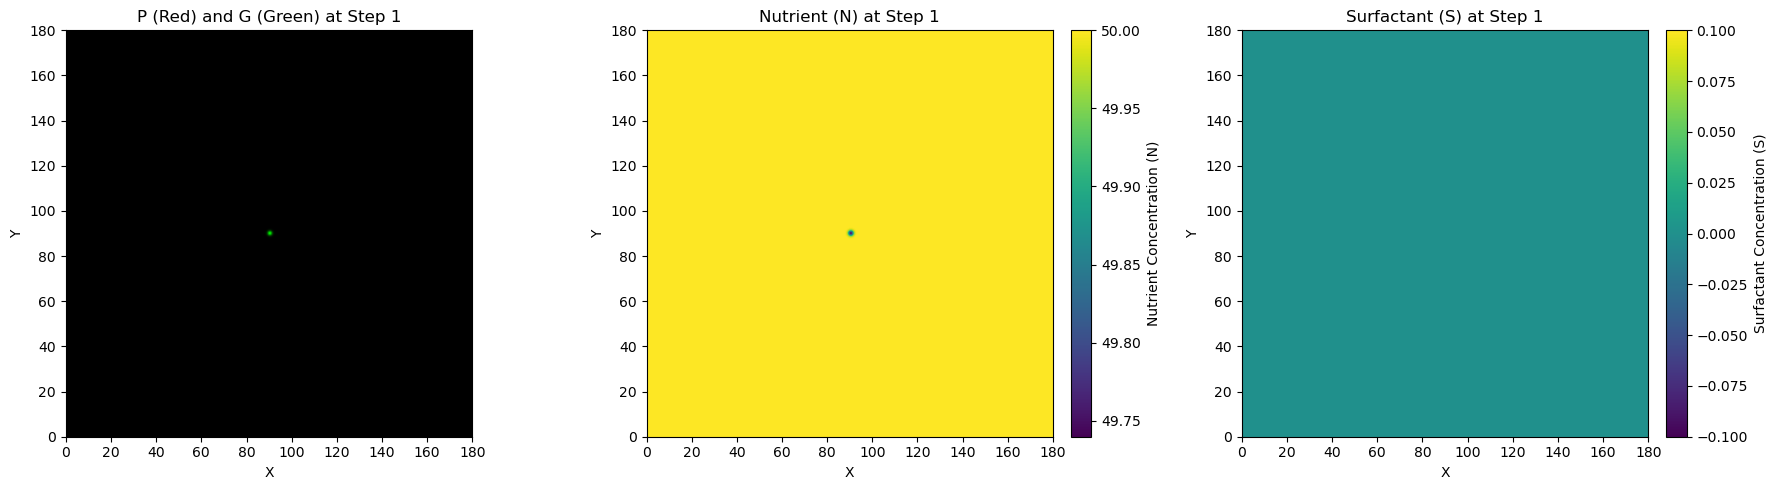

Step 0: Time = 0.00, Colony Radius = 1.6476


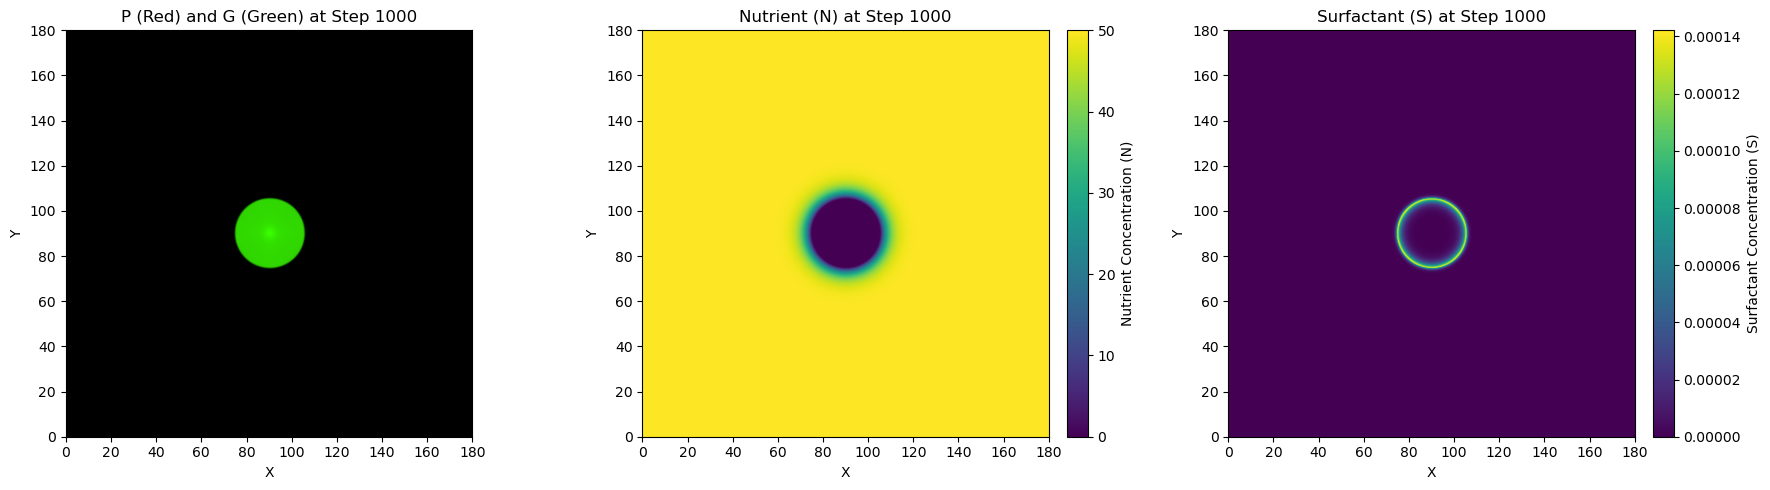

Step 999: Time = 3.00, Colony Radius = 16.0894


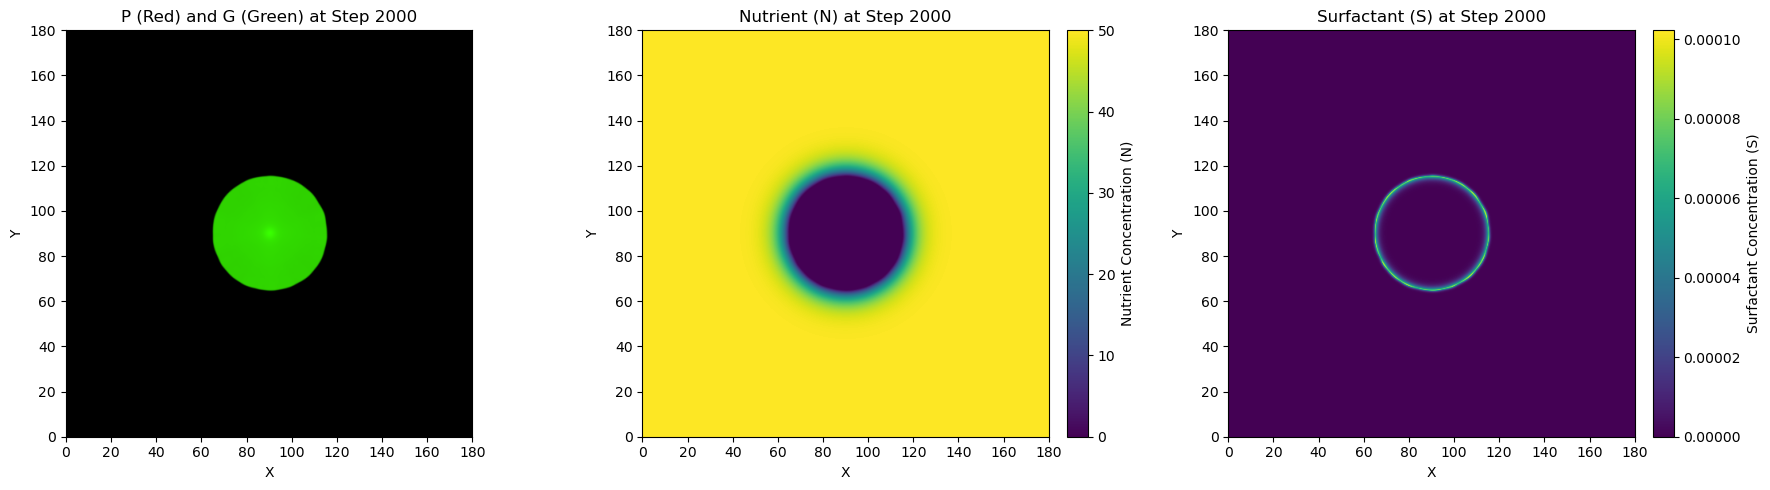

Step 1999: Time = 6.00, Colony Radius = 25.9790


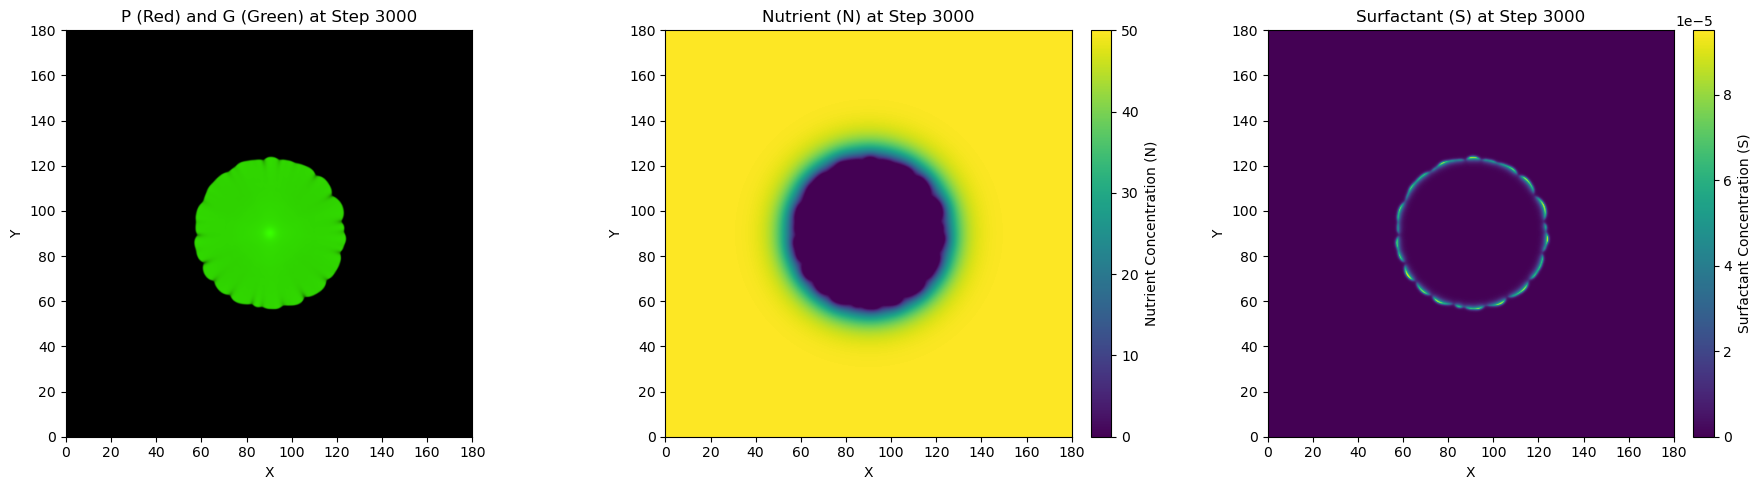

Step 2999: Time = 9.00, Colony Radius = 33.9610


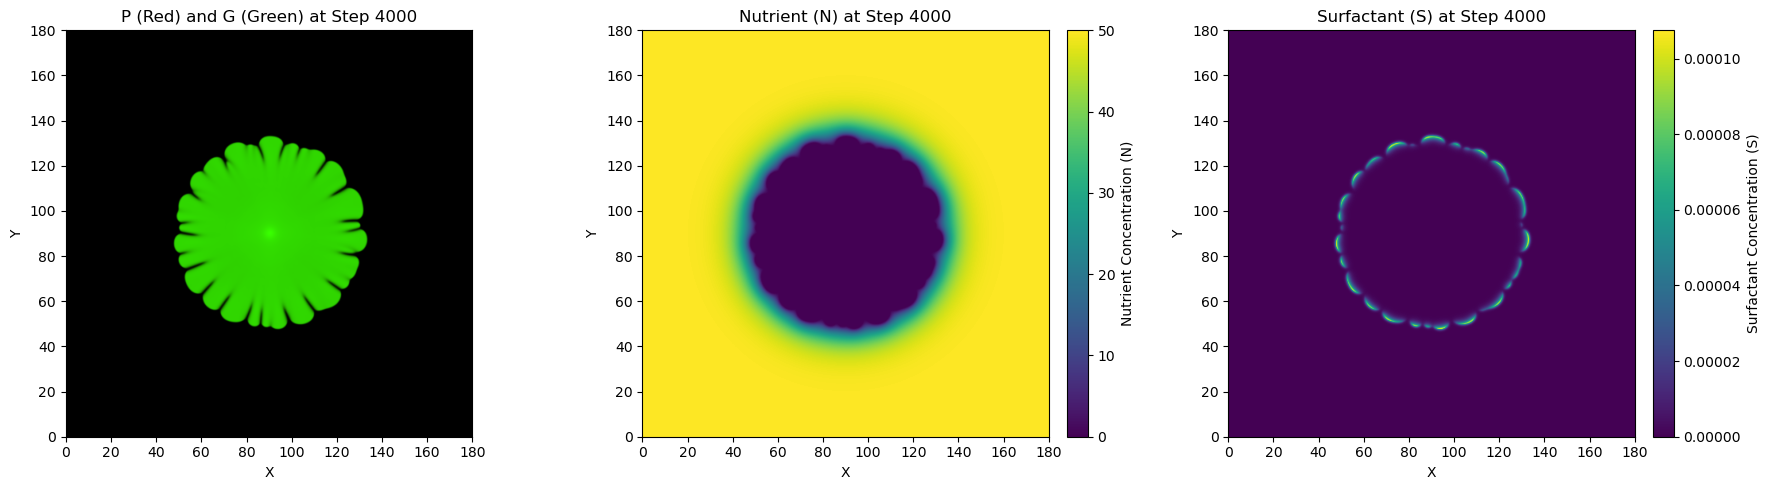

Step 3999: Time = 12.00, Colony Radius = 42.2416


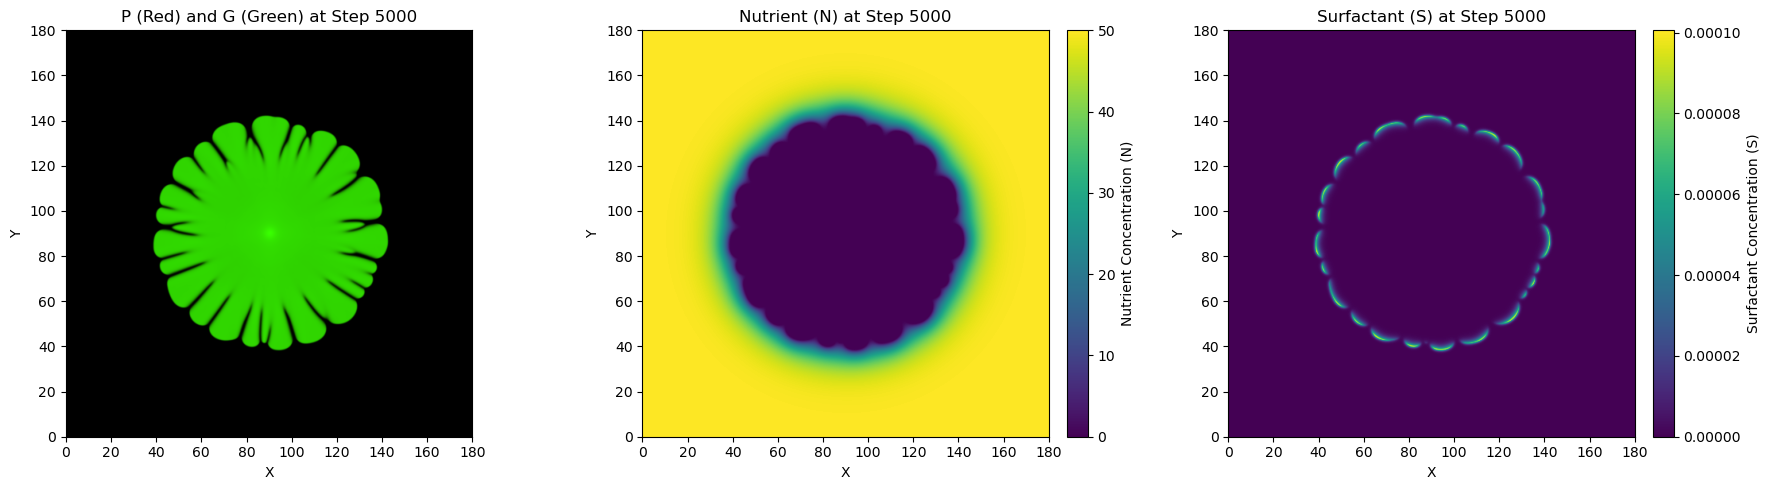

Step 4999: Time = 15.00, Colony Radius = 51.0028


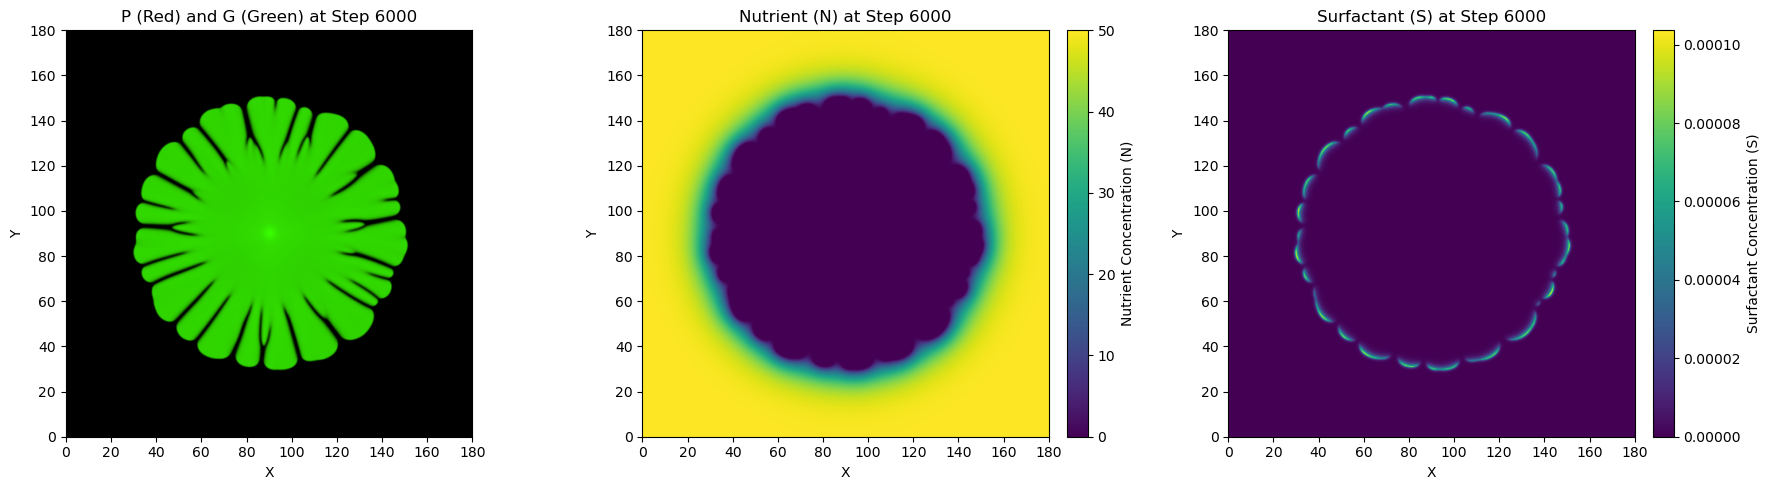

Step 5999: Time = 18.00, Colony Radius = 59.5827


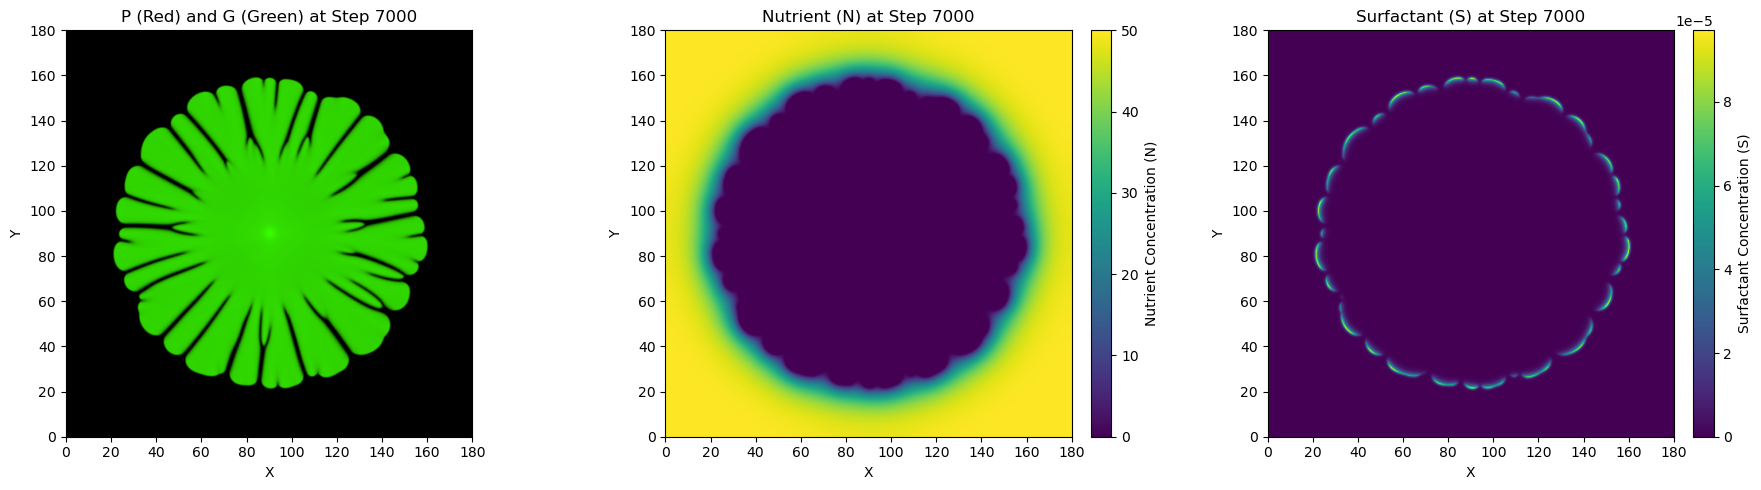

Step 6999: Time = 21.00, Colony Radius = 67.7752


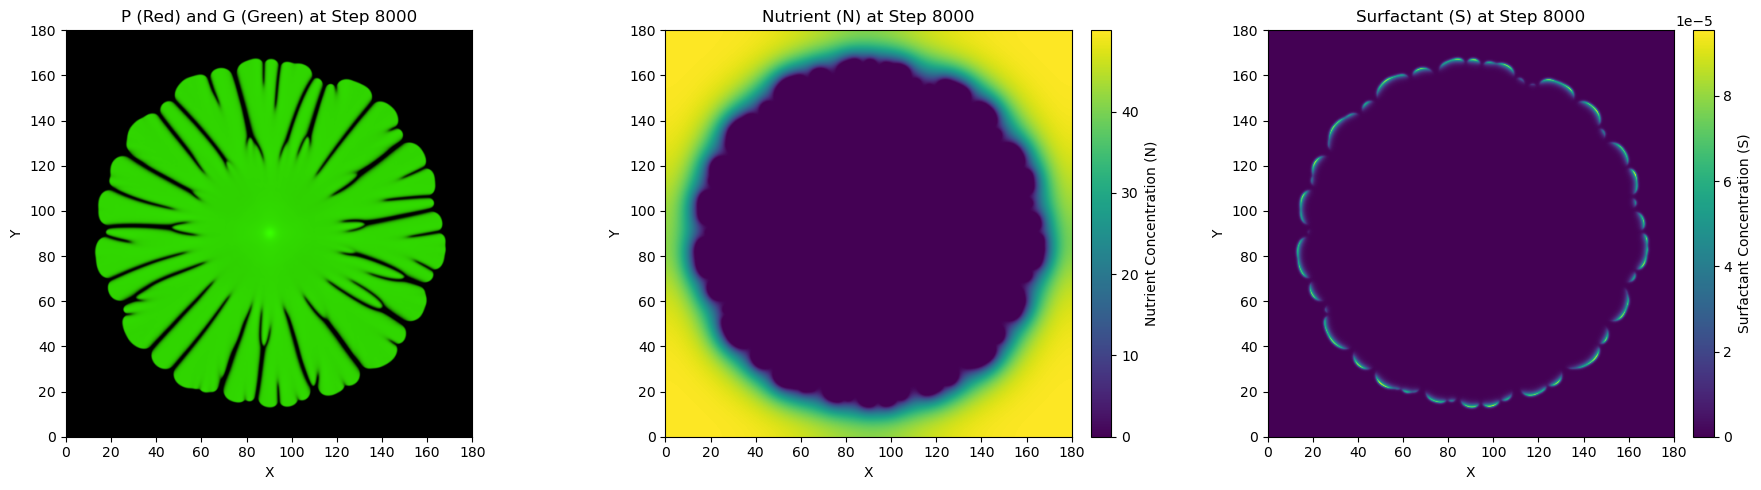

Step 7999: Time = 24.00, Colony Radius = 75.6351


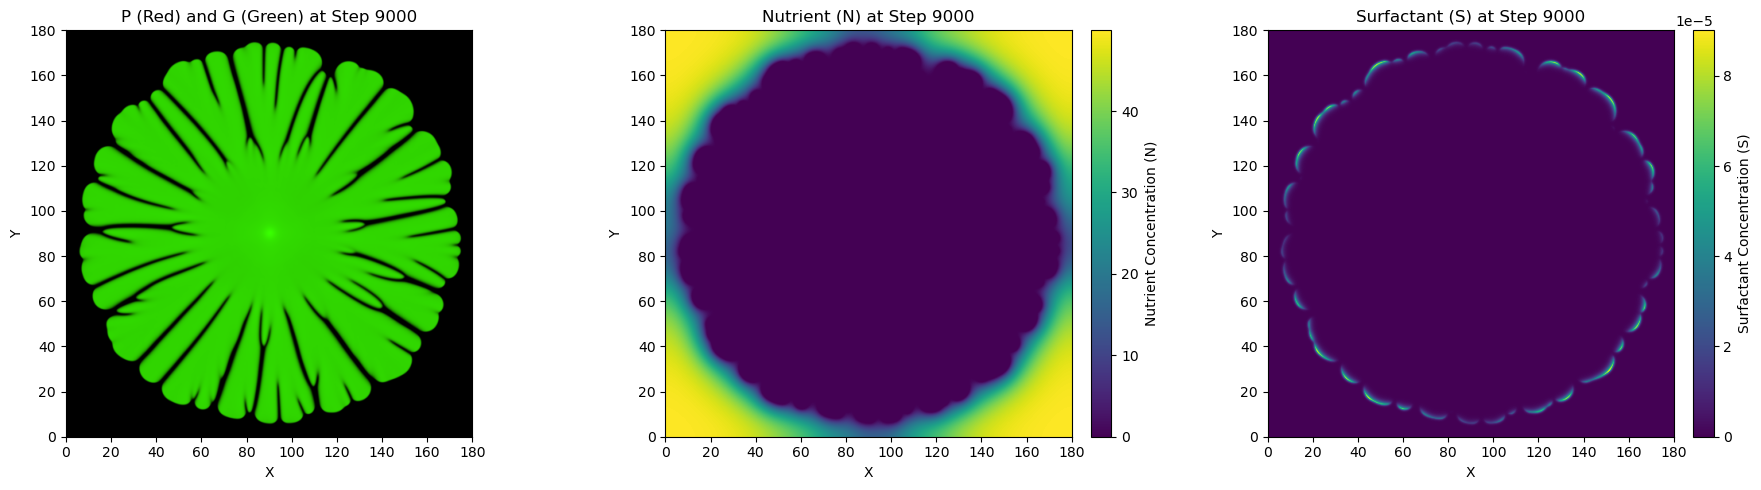

Step 8999: Time = 27.00, Colony Radius = 82.9623


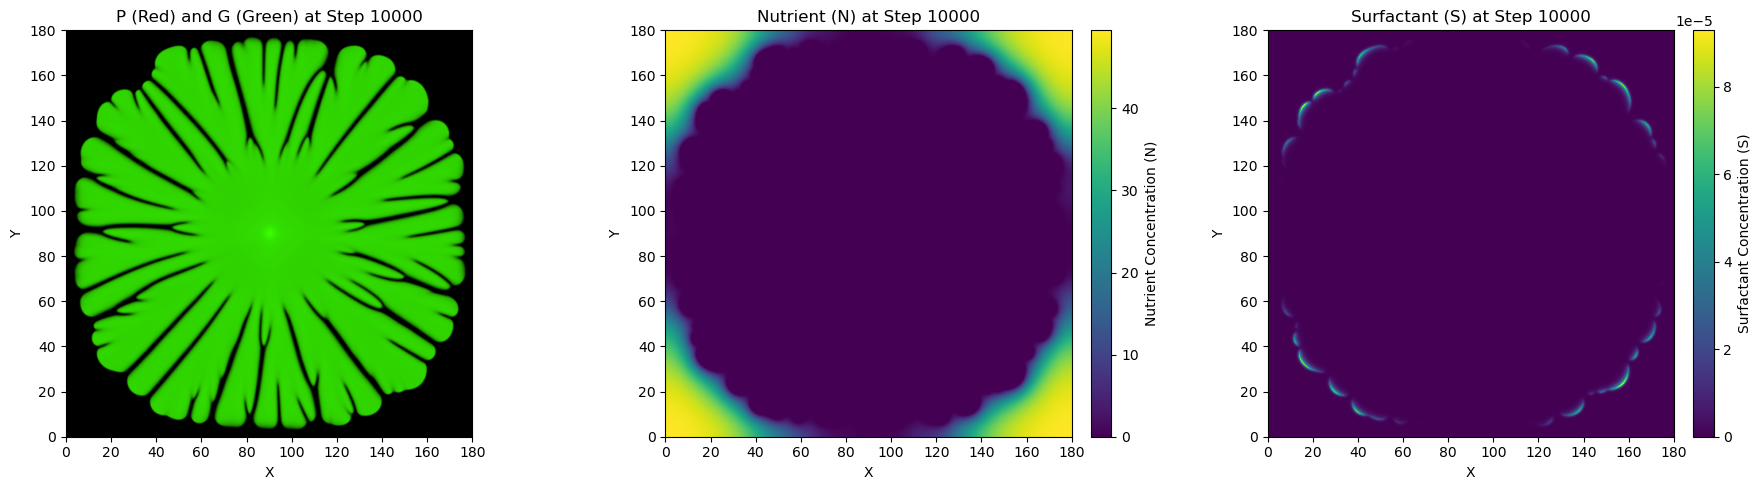

Step 9999: Time = 30.00, Colony Radius = 88.5223
Simulation completed.
Total simulation time: 18.33 seconds


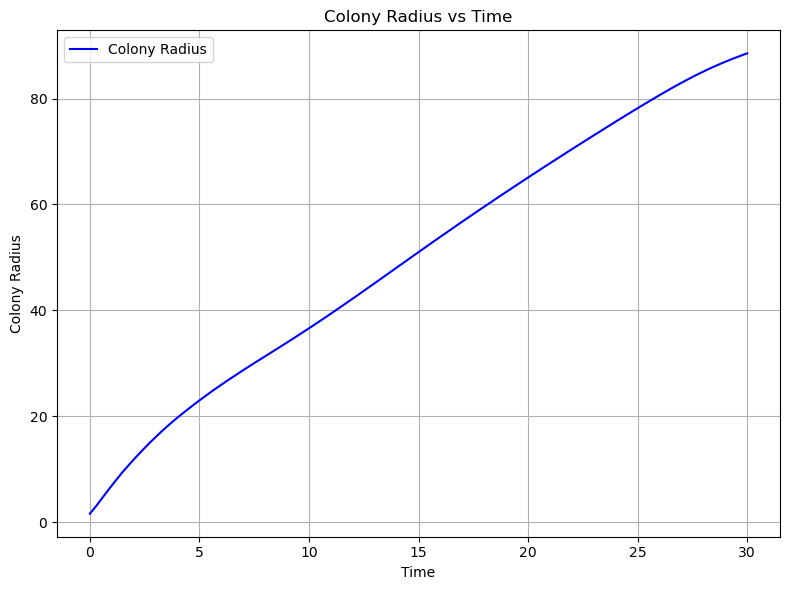

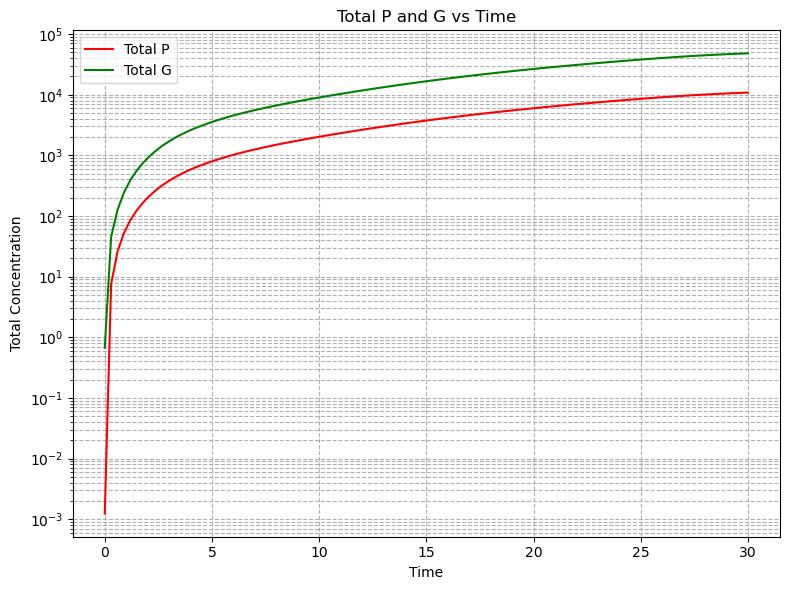

Simulation took 18.92 seconds


In [120]:
# Define namedtuple for parameters for better readability
Parameters = namedtuple('Parameters', [
    'DN', 'DS', 'kD', 'bN', 'aG', 'aP', 'kG', 'kP',
    'KN', 'KT', 'aS', 'bS', 'KE', 'KC', 'Cmax',
    'n', 'd', 'a', 'b', 'KP', 'N0', 'C0'
])

def run_simulation_implicit_variable_D():
    """
    Runs the PDE simulation for nutrient concentration (N), proliferating cells (P),
    specialized cells (G), and surfactant (S), using an implicit finite difference method
    that accurately handles spatially varying diffusivities.
    Injects noise into the effective diffusivity D_eff.
    Computes colony area by thresholding C > 0.01 and plots colony radius as a function of time.
    """
    # Define grid parameters
    nx, ny = 512, 512  # Number of grid points
    Lx, Ly = 180, 180  # Physical domain size
    dx = Lx / nx
    dy = Ly / ny

    # Define total simulation time and steps
    dt = 3e-3  # Increased time step due to implicit method
    nt = 10000  # Number of time steps (reduced due to larger dt)
    frames = 10
    samples = 100

    # Define PDE parameters using namedtuple for clarity
    params = Parameters(
        DN=20.0,        # Nutrient diffusivity 20
        DS=5.79,      # Surfactant diffusivity 5.79
        kD=5e3,        # Diffusion scaling 2e3
        bN=22.0,       # Nutrient consumption rate
        aG=24.24,      # Grower growth rate
        aP=8.67,       # Producer growth rate
        kG=75.36,      # Producer decay rate
        kP=16.98,      # Producer to grower conversion rate
        KN=1.0,        # Nutrient half-saturation constant
        KT=10.0,       # Transition function constant
        aS=1.0,        # Surfactant production rate
        bS=5.0,        # Surfactant decay rate
        KE=9.0,        # Surfactant production function constant
        KC=6.0,        # Surfactant production function constant
        Cmax=10.0,     # Maximum cell density
        n=2.0,         # Transition function exponent
        d=2.205,       # Surfactant production function exponent
        a=1.69,        # Surfactant production function parameter
        b=1.84,        # Surfactant production function parameter
        KP=3.21,       # Surfactant production function constant
        N0=50.0,       # Initial nutrient concentration
        C0=0.2         # Initial cell concentration
    )

    print("Simulation Parameters:")
    print(params)

    # Define initial conditions
    N_initial, P_initial, G_initial, S_initial = initialize_fields(nx, ny, Lx, Ly, params.N0, params.C0)
    pde_state = (N_initial, P_initial, G_initial, S_initial)

    # Define noise parameters
    epsilon = 0.2  # Noise amplitude

    # Initialize PRNG key
    seed = 42  # Arbitrary seed for reproducibility
    key = jax.random.PRNGKey(seed)

    # Initialize lists to store colony radius, time, total P, and total G
    colony_radius_list = []
    time_list = []
    total_P_list = []
    total_G_list = []

    # Define threshold for colony
    C_threshold = 0.01

    # Compute cell area
    cell_area = dx * dy

    # Create directory to save outputs (optional)
    save_dir = 'simulation_outputs_implicit_variable_D'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Simulation loop
    start_time = time.time()
    for step in range(nt):
        # Generate a new random key for this step
        key, subkey = jax.random.split(key)

        # Generate noise: Uniform noise with amplitude epsilon
        noise = epsilon * (jax.random.uniform(subkey, shape=(nx, ny)) * 2 - 1)

        # Update PDE state with operator splitting (explicit reaction and implicit diffusion)
        pde_state = pde_implicit(
            pde_state,
            params,
            dx,
            dy,
            dt,
            noise
        )

        # Extract updated N, P, G, S
        N, P, G, S = pde_state

        # Compute total cell density C = P + G
        C = P + G

        # Data collection at specified intervals
        if (step == 0) or ((step + 1) % (nt//samples) == 0):
            # Compute colony area by thresholding C > C_threshold
            colony_mask = C > C_threshold
            colony_area = jnp.sum(colony_mask) * cell_area

            # Compute colony radius assuming circular colony
            colony_radius = jnp.sqrt(colony_area / jnp.pi)
            colony_radius_list.append(colony_radius)
            time_list.append(step * dt)

            # Compute total P and G across the space
            total_P = jnp.sum(P) * cell_area
            total_G = jnp.sum(G) * cell_area
            total_P_list.append(total_P)
            total_G_list.append(total_G)

        # Visualization at specified intervals
        if (step == 0) or ((step+1) % (nt//frames) == 0):
            plt.figure(figsize=(18, 5))

            # Create composite RGB image for P and G
            composite_image = jnp.stack([P, G, jnp.zeros_like(P)], axis=-1)
            composite_image = composite_image / (composite_image.max() + 1e-8)  # Normalize to [0, 1]

            # Plot Composite Image of P and G
            plt.subplot(1, 3, 1)
            plt.imshow(composite_image, extent=(0, Lx, 0, Ly), origin='lower')
            plt.title(f'P (Red) and G (Green) at Step {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot N (Nutrient Concentration)
            plt.subplot(1, 3, 2)
            im_n = plt.imshow(N, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            cbar_n = plt.colorbar(im_n, fraction=0.046, pad=0.04)
            cbar_n.ax.set_ylabel('Nutrient Concentration (N)')
            plt.title(f'Nutrient (N) at Step {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            # Plot S (Surfactant Concentration)
            plt.subplot(1, 3, 3)
            im_s = plt.imshow(S, extent=(0, Lx, 0, Ly), origin='lower', cmap='viridis')
            cbar_s = plt.colorbar(im_s, fraction=0.046, pad=0.04)
            cbar_s.ax.set_ylabel('Surfactant Concentration (S)')
            plt.title(f'Surfactant (S) at Step {step + 1}')
            plt.xlabel('X')
            plt.ylabel('Y')

            plt.tight_layout()
            plt.show()
            # Optionally, save the plots
            # plt.savefig(os.path.join(save_dir, f'step_{step}.png'))
            # plt.close()

            # Print progress and colony radius
            print(f"Step {step}: Time = {step*dt:.2f}, Colony Radius = {colony_radius:.4f}")

    end_time = time.time()
    print("Simulation completed.")
    print(f"Total simulation time: {end_time - start_time:.2f} seconds")

    # Convert lists to NumPy arrays for plotting
    colony_radius_array = jnp.array(colony_radius_list)
    time_array = jnp.array(time_list)
    total_P_array = jnp.array(total_P_list)
    total_G_array = jnp.array(total_G_list)

    # Plot Colony Radius vs Time
    plt.figure(figsize=(8, 6))
    plt.plot(time_array, colony_radius_array, label='Colony Radius', color='blue')
    plt.xlabel('Time')
    plt.ylabel('Colony Radius')
    plt.title('Colony Radius vs Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'colony_radius_vs_time_implicit_variable_D.png'))

    # Plot Total P and G vs Time (log scale for y-axis)
    plt.figure(figsize=(8, 6))
    plt.plot(time_array, total_P_array, label='Total P', color='red')
    plt.plot(time_array, total_G_array, label='Total G', color='green')
    plt.xlabel('Time')
    plt.ylabel('Total Concentration')
    plt.title('Total P and G vs Time')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.tight_layout()
    plt.show()
    # Optionally, save the plot
    # plt.savefig(os.path.join(save_dir, 'total_P_G_vs_time_implicit_variable_D.png'))

start = time.time()
run_simulation_implicit_variable_D()
end = time.time()
print(f"Simulation took {end - start:.2f} seconds")
